In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cvae_featurization import *
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from cvae import TempTimeGenerator

Using TensorFlow backend.


In [ ]:
imputation_strategy="one_hot"
featurization="pca"
only_ss_rxns, ss_precursor_nomenclature = impute_data(imputation_strategy)
df, prec_magpie_feats = featurize(featurization, only_ss_rxns, ss_precursor_nomenclature)

Returning extracted data of 51574/31782 reactions.


In [7]:
prec_magpie_feats

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
objective = "temp_time_vector"
omit_columns = ['targets', 'precursors', objective, 'composition_obj']
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = objective
X_df = df[X_columns]
X_columns = list(X_df.columns)
X = X_df.values
y = df[y_column].values

X, y, prec_magpie_feats, full_df = shuffle(X, y, prec_magpie_feats, df, random_state=42)

y = np.vstack(y)
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

In [ ]:
def get_unique_test_set(df):
    test_results = []
    unique_inds = []
    for i, (target, precs, temps) in enumerate(zip(df['targets'], df['precursors'], df['temp_time_vector'])):
        found = False
        for result in test_results:
            if result["Target"] == target and set(result["Precursors"]) == set(precs):
                result["temp_time_vector"].append(temps)
                found = True
        if not found:
            new_result = {}
            new_result["Target"] = target
            new_result["Precursors"] = precs
            new_result["temp_time_vector"] = [temps]
            test_results.append(new_result)
            unique_inds.append(i)
    return test_results, np.array(unique_inds)

In [ ]:
best_params = []
y_pred_train, y_pred_test = [], []
X_train_k, X_test_k = [], []
y_train_k, y_test_k = [], []
n_pts_train_k, n_pts_test_k = [], []
histories = []

kf = KFold(n_splits=10, shuffle=False)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    df_train, df_test = full_df.iloc[train_index], full_df.iloc[test_index]
    
    prec_magpie_feats_train, prec_magpie_feats_test = prec_magpie_feats[train_index], prec_magpie_feats[test_index]
    X_train_curr, X_val, y_train_curr, y_val, prec_magpie_feats_train_curr, prec_magpie_feats_val = train_test_split(X_train, y_train, prec_magpie_feats_train, test_size=0.2, shuffle=False)
    
    scaler = StandardScaler()
    scaler.fit(y_train_curr)
    y_train_curr = scaler.transform(y_train_curr)
    y_val = scaler.transform(y_val)
    
    y_train_curr = np.reshape(y_train_curr, (-1, 8, 1))
    y_val = np.reshape(y_val, (-1, 8, 1))
    
    train_inputs = [y_train_curr, X_train_curr, prec_magpie_feats_train_curr]
    train_outputs = [y_train_curr]
    
    val_data = [[y_val, X_val, prec_magpie_feats_val], y_val]
    
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model()
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=100,
        val_split=0,
        val_data=val_data,
        batch_size=128,
        callbacks=callbacks,
        verbose=2
    )
    
    histories.append(history)
    
    epochs = len(history['val_loss'])
    
    best_params.append(epochs)
    
    del temp_gen
    
    scaler = StandardScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_train = np.reshape(y_train, (-1, 8, 1))
    
    train_inputs = [y_train, X_train, prec_magpie_feats_train]
    train_outputs = [y_train]
    
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model()

    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=epochs,
        val_split=0,
        val_data=None,
        batch_size=128,
        callbacks=None,
        verbose=2
    )
    
    test_results, unique_inds = get_unique_test_set(df_test)
    
    results = []
    for i in unique_inds:
        conds = temp_gen.generate_samples(target_material=X_test[i:i+1], precursors=prec_magpie_feats_test[i:i+1], n_samples=1000)
        curr_results = []
        for conditions in conds:
            temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
            curr_results.append(temp_time)
        curr_results = np.vstack(curr_results)
        results.append(curr_results)
    results = np.array(results)
    
    y_pred_test.append(results)
    y_test_k.append(test_results)
  

In [6]:
best_params = []
y_pred_train, y_pred_test = [], []
X_train_k, X_test_k = [], []
y_train_k, y_test_k = [], []
n_pts_train_k, n_pts_test_k = [], []
histories = []

kf = KFold(n_splits=10, shuffle=False)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    df_train, df_test = full_df.iloc[train_index], full_df.iloc[test_index]
    
    prec_magpie_feats_train, prec_magpie_feats_test = prec_magpie_feats[train_index], prec_magpie_feats[test_index]
    X_train_curr, X_val, y_train_curr, y_val, prec_magpie_feats_train_curr, prec_magpie_feats_val = train_test_split(X_train, y_train, prec_magpie_feats_train, test_size=0.2, shuffle=False)
    
    scaler = StandardScaler()
    scaler.fit(X_train_curr)
    X_train_curr = scaler.transform(X_train_curr)
    X_val = scaler.transform(X_val)
    
    scaler = StandardScaler()
    scaler.fit(prec_magpie_feats_train_curr)
    prec_magpie_feats_train_curr = scaler.transform(prec_magpie_feats_train_curr)
    prec_magpie_feats_val = scaler.transform(prec_magpie_feats_val)
    
    scaler = StandardScaler()
    scaler.fit(y_train_curr)
    y_train_curr = scaler.transform(y_train_curr)
    y_val = scaler.transform(y_val)
    
    y_train_curr = np.reshape(y_train_curr, (-1, 8, 1))
    y_val = np.reshape(y_val, (-1, 8, 1))
    
    train_inputs = [y_train_curr, X_train_curr, prec_magpie_feats_train_curr]
    train_outputs = [y_train_curr]
    
    val_data = [[y_val, X_val, prec_magpie_feats_val], y_val]
    
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model(precursor_len=prec_magpie_feats.shape[-1], intermediate_dim=32)
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=500,
        val_split=0,
        val_data=val_data,
        batch_size=128,
        callbacks=callbacks,
        verbose=2
    )
    
    histories.append(history)
    
    epochs = len(history['val_loss'])
    
    best_params.append(epochs)
    
    del temp_gen
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    scaler = StandardScaler()
    scaler.fit(prec_magpie_feats_train)
    prec_magpie_feats_train = scaler.transform(prec_magpie_feats_train)
    prec_magpie_feats_test = scaler.transform(prec_magpie_feats_test)
    
    scaler = StandardScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_train = np.reshape(y_train, (-1, 8, 1))
    
    train_inputs = [y_train, X_train, prec_magpie_feats_train]
    train_outputs = [y_train]
    
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model(precursor_len=prec_magpie_feats.shape[-1])

    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=epochs,
        val_split=0,
        val_data=None,
        batch_size=128,
        callbacks=None,
        verbose=2
    )
    
    test_results, unique_inds = get_unique_test_set(df_test)
    
    results = []
    for i in unique_inds:
        conds = temp_gen.generate_samples(target_material=X_test[i:i+1], precursors=prec_magpie_feats_test[i:i+1], n_samples=1000)
        curr_results = []
        for conditions in conds:
            temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
            curr_results.append(temp_time)
        curr_results = np.vstack(curr_results)
        results.append(curr_results)
    results = np.array(results)
    
    y_pred_test.append(results)
    y_test_k.append(test_results)
  

Train on 22349 samples, validate on 5588 samples
Epoch 1/100
 - 11s - loss: 6.7485 - mean_squared_error: 0.8219 - val_loss: 5.8847 - val_mean_squared_error: 0.6896
Epoch 2/100
 - 2s - loss: 5.4219 - mean_squared_error: 0.6323 - val_loss: 5.3846 - val_mean_squared_error: 0.6313
Epoch 3/100
 - 2s - loss: 5.0664 - mean_squared_error: 0.5883 - val_loss: 4.9874 - val_mean_squared_error: 0.5733
Epoch 4/100
 - 2s - loss: 4.8289 - mean_squared_error: 0.5487 - val_loss: 4.7832 - val_mean_squared_error: 0.5382
Epoch 5/100
 - 2s - loss: 4.6084 - mean_squared_error: 0.5091 - val_loss: 4.7210 - val_mean_squared_error: 0.5128
Epoch 6/100
 - 2s - loss: 4.4225 - mean_squared_error: 0.4812 - val_loss: 4.7851 - val_mean_squared_error: 0.5172
Epoch 7/100
 - 2s - loss: 4.3337 - mean_squared_error: 0.4657 - val_loss: 4.3604 - val_mean_squared_error: 0.4657
Epoch 8/100
 - 2s - loss: 4.2691 - mean_squared_error: 0.4516 - val_loss: 4.3715 - val_mean_squared_error: 0.4670
Epoch 9/100
 - 2s - loss: 4.1692 - mea

 - 2s - loss: 2.9759 - mean_squared_error: 0.2636
Epoch 39/51
 - 2s - loss: 2.9409 - mean_squared_error: 0.2585
Epoch 40/51
 - 2s - loss: 2.9813 - mean_squared_error: 0.2587
Epoch 41/51
 - 2s - loss: 2.9485 - mean_squared_error: 0.2584
Epoch 42/51
 - 2s - loss: 2.9430 - mean_squared_error: 0.2578
Epoch 43/51
 - 2s - loss: 2.9055 - mean_squared_error: 0.2532
Epoch 44/51
 - 2s - loss: 2.8843 - mean_squared_error: 0.2514
Epoch 45/51
 - 2s - loss: 2.8837 - mean_squared_error: 0.2499
Epoch 46/51
 - 2s - loss: 2.9192 - mean_squared_error: 0.2511
Epoch 47/51
 - 2s - loss: 2.9013 - mean_squared_error: 0.2500
Epoch 48/51
 - 2s - loss: 2.8867 - mean_squared_error: 0.2497
Epoch 49/51
 - 2s - loss: 2.9037 - mean_squared_error: 0.2495
Epoch 50/51
 - 2s - loss: 2.8727 - mean_squared_error: 0.2468
Epoch 51/51
 - 2s - loss: 2.8781 - mean_squared_error: 0.2458
Train on 22349 samples, validate on 5588 samples
Epoch 1/100
 - 12s - loss: 6.9032 - mean_squared_error: 0.8506 - val_loss: 5.7805 - val_mean_sq

Epoch 25/51
 - 2s - loss: 3.1457 - mean_squared_error: 0.3017
Epoch 26/51
 - 3s - loss: 3.2106 - mean_squared_error: 0.3049
Epoch 27/51
 - 3s - loss: 3.1583 - mean_squared_error: 0.2978
Epoch 28/51
 - 2s - loss: 3.1887 - mean_squared_error: 0.2985
Epoch 29/51
 - 2s - loss: 3.1036 - mean_squared_error: 0.2894
Epoch 30/51
 - 3s - loss: 3.1748 - mean_squared_error: 0.2933
Epoch 31/51
 - 2s - loss: 3.1064 - mean_squared_error: 0.2855
Epoch 32/51
 - 2s - loss: 3.1214 - mean_squared_error: 0.2844
Epoch 33/51
 - 3s - loss: 3.1011 - mean_squared_error: 0.2850
Epoch 34/51
 - 2s - loss: 3.0490 - mean_squared_error: 0.2790
Epoch 35/51
 - 2s - loss: 3.0473 - mean_squared_error: 0.2770
Epoch 36/51
 - 2s - loss: 3.0252 - mean_squared_error: 0.2751
Epoch 37/51
 - 2s - loss: 2.9840 - mean_squared_error: 0.2699
Epoch 38/51
 - 2s - loss: 2.9951 - mean_squared_error: 0.2702
Epoch 39/51
 - 2s - loss: 3.0048 - mean_squared_error: 0.2720
Epoch 40/51
 - 2s - loss: 3.0004 - mean_squared_error: 0.2677
Epoch 41

Epoch 19/47
 - 2s - loss: 3.3287 - mean_squared_error: 0.3315
Epoch 20/47
 - 2s - loss: 3.3709 - mean_squared_error: 0.3343
Epoch 21/47
 - 2s - loss: 3.2892 - mean_squared_error: 0.3246
Epoch 22/47
 - 3s - loss: 3.2823 - mean_squared_error: 0.3231
Epoch 23/47
 - 2s - loss: 3.2559 - mean_squared_error: 0.3212
Epoch 24/47
 - 2s - loss: 3.2055 - mean_squared_error: 0.3136
Epoch 25/47
 - 2s - loss: 3.2031 - mean_squared_error: 0.3168
Epoch 26/47
 - 2s - loss: 3.1837 - mean_squared_error: 0.3100
Epoch 27/47
 - 2s - loss: 3.1910 - mean_squared_error: 0.3103
Epoch 28/47
 - 2s - loss: 3.1387 - mean_squared_error: 0.3041
Epoch 29/47
 - 2s - loss: 3.1300 - mean_squared_error: 0.3022
Epoch 30/47
 - 2s - loss: 3.1654 - mean_squared_error: 0.3052
Epoch 31/47
 - 2s - loss: 3.1017 - mean_squared_error: 0.2990
Epoch 32/47
 - 2s - loss: 3.0920 - mean_squared_error: 0.3000
Epoch 33/47
 - 2s - loss: 3.0957 - mean_squared_error: 0.2979
Epoch 34/47
 - 2s - loss: 3.0655 - mean_squared_error: 0.2960
Epoch 35

KeyboardInterrupt: 

In [ ]:
mapping = {
    "calcine_temp": 0,
    "sinter_temp": 1,
    "anneal_temp": 2,
    "dry_temp": 3,
    "calcine_time": 4,
    "sinter_time": 5,
    "anneal_time": 6,
    "dry_time": 7
}
results = []
for key in mapping:
    i = mapping[key]
    maes, rmses, mres, r2s = [], [], [], []
    contained, pred_contained = [], []
    for fold in range(10):
        y_pred = np.mean(y_pred_test[fold], axis=1)
        y_true = np.vstack([np.mean(x['temp_time_vector'], axis=0) for x in y_test_k[fold]])
        rmses.append(mean_squared_error(y_true[:, i], y_pred[:, i], squared=False))
        maes.append(mean_absolute_error(y_true[:, i], y_pred[:, i]))
        mres.append(np.mean((np.abs(y_true[:, i]-y_pred[:, i])/y_true[:, i])*100))
        r2s.append(r2_score(y_true[:, i], y_pred[:, i]))
        
        num_contained = 0
        num_pred_contained = 0
        num_pred = 0
        true_vals = [x['temp_time_vector'] for x in y_test_k[fold]]
        for ind in range(y_true.shape[0]):
            if min(y_pred_test[fold][ind, :, i]) <= y_true[ind][i] <= max(y_pred_test[fold][ind, :, i]):
                num_contained += 1
            if len(true_vals[ind]) > 5:
                exp_min = min(np.vstack(true_vals[ind])[:, i])
                exp_max = max(np.vstack(true_vals[ind])[:, i])
                num_pred += 1
                if exp_min <= y_pred[ind, i] <= exp_max:
                    num_pred_contained += 1
                    
        pred_contained.append(num_pred_contained / num_pred)
        contained.append(num_contained / y_true.shape[0])
                   
    result = {
        "objective": key,
        "model": "CVAE",
        "imputation_strategy": imputation_strategy,
        "featurization": featurization,
        "MAE": str(np.mean(maes)),
        "MAE_std": str(np.std(maes)),
        "RMSE": str(np.mean(rmses)),
        "RMSE_std": str(np.std(rmses)),
        "MRE": str(np.mean(mres)),
        "MRE_std": str(np.std(mres)),
        "R2": str(np.mean(r2s)),
        "R2_std": str(np.std(r2s)),
        "Percent_exp_means_contained": str(np.mean(contained) * 100),
        "Percent_exp_means_contained_std": str(np.std(contained) * 100),
        "Percent_pred_means_contained": str(np.mean(pred_contained) * 100),
        "Percent_pred_means_contained_std": str(np.std(pred_contained) * 100)
    }
    results.append(result)

In [196]:
results

[{'objective': 'calcine_temp',
  'model': 'CVAE',
  'featurization': 'PCA',
  'MAE': '120.7849837589007',
  'MAE_std': '2.8716770110044108',
  'RMSE': '162.86135210918928',
  'RMSE_std': '2.518832815313463',
  'MRE': '14.465894214214208',
  'MRE_std': '0.4874248231249989',
  'R2': '0.487982553013757',
  'R2_std': '0.017390772168171243',
  'Percent_exp_means_contained': '62.77753207391853',
  'Percent_exp_means_contained_std': '4.579632397616285',
  'Percent_pred_means_contained': '96.66233766233766',
  'Percent_pred_means_contained_std': '5.247155057264257'},
 {'objective': 'sinter_temp',
  'model': 'CVAE',
  'featurization': 'PCA',
  'MAE': '115.97275766113373',
  'MAE_std': '2.243014879910936',
  'RMSE': '158.3833678237741',
  'RMSE_std': '2.6937494195667915',
  'MRE': '12.181855510522846',
  'MRE_std': '0.6187637905599901',
  'R2': '0.655172651708513',
  'R2_std': '0.007171192925364303',
  'Percent_exp_means_contained': '72.72934027728715',
  'Percent_exp_means_contained_std': '7.66

In [ ]:
featurization="mp_fraction"
imputation_strategy="one_hot"
with open('data/' + imputation_strategy + '_' + featurization + ".json", "w") as f:
    json.dump(results, f, indent=4)

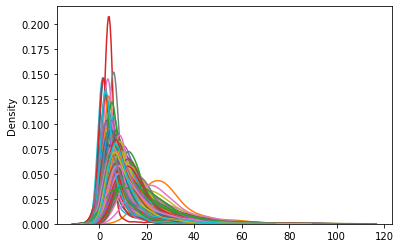

In [123]:
temp = np.vstack([np.mean(x['temp_time_vector'], axis=0) for x in y_test_k[fold]])
true_scatter = []
for i in range(500, 800):
    mean = np.mean(y_pred_test[fold][i, :, 5])
    # sns.kdeplot(y_pred_test[fold][i, :, 1] - mean, color = (0.1, 0.3, 0.5, 0.15))
    sns.kdeplot(y_pred_test[fold][i, :, 5])
    true_scatter.append(temp[i][1] - mean)
# for i in range(100):
#      plt.axvline(x=true_scatter[i], color='r', linewidth=2, alpha=0.1)

In [189]:
np.vstack([x['temp_time_vector'] for x in y_test_k[fold]][5])[:, 1]

array([1000., 1250.])